In [1]:
import pandas as pd
import numpy as np
import pyreadr
import matplotlib.pyplot as plt
import seaborn as sns
import zstandard as zstd  

In [3]:
data_d = '~/data/1_Single_Cell_PRS/2_cV2F'
tissue = ['all', 'BLOOD', 'KIDNEY', 'LUNG', 'LIVER']
trait = pd.read_csv(f'{data_d}/pheno_tissue.txt', header=None)[0].tolist()
data_d = f'{data_d}/mvp_afr_0.9_0.01/20231221/406k_geno_v2_UKB_18PCs/fit_w_val/'

evals = []
for t in tissue:
    for tr in trait:
        if tr == 'INI20030780':
            df = pd.read_csv(f"{data_d}{t}/{tr}/exclude_APOE/snpnet.eval.tsv.gz", sep='\t', compression='gzip')
        else:
            df = pd.read_csv(f"{data_d}{t}/{tr}/snpnet.eval.tsv.gz", sep='\t', compression='gzip')

        df['tissue'] = t  # Ensure tissue assignment happens for each trait
        df = df[(df['split'] == 'test') & (df['population'] == 'Afr') & (df['model'] == 'PGS')]
        
        evals.append(df)  # Append inside the loop

        
for tr in trait:
    if tr == 'INI20030780':
        baseline_eval = pd.read_csv(f"~/data/1_Single_Cell_PRS/2_cV2F/baselines/406k_geno_v2_UKB_18PCs/fit_w_val/{tr}/exclude_APOE/snpnet.eval.tsv.gz", sep='\t', compression='gzip')
    else:
        baseline_eval = pd.read_csv(f"~/data/1_Single_Cell_PRS/2_cV2F/baselines/406k_geno_v2_UKB_18PCs/fit_w_val/{tr}/snpnet.eval.tsv.gz", sep='\t', compression='gzip')
    #baseline_eval = pd.read_csv('baselines/406k_geno_v2_UKB_18PCs/fit_w_val/' + tr + '/snpnet.eval.tsv.gz', sep='\t', compression='gzip')
    baseline_eval['tissue'] = 'baseline'
    baseline_eval = baseline_eval[(baseline_eval['split'] == 'test') & (baseline_eval['population'] == 'Afr') & (baseline_eval['model'] == 'PGS')]
    evals.append(baseline_eval)

In [4]:
eval_dfs = pd.concat(evals)

In [5]:
from matplotlib.patches import Patch
palette = sns.color_palette(palette='Paired')

handles = [Patch(facecolor=palette[4], label = 'BLOOD'), 
          Patch(facecolor=palette[0], label = 'KIDNEY'),
          Patch(facecolor=palette[2], label = 'LUNG'),
          Patch(facecolor=palette[6], label = 'LIVER'), 
          Patch(facecolor=palette[-4], label = 'all')]

handles_index = ['BLOOD', 'KIDNEY', 'LUNG', 'LIVER', 'all']
handles_color = [palette[4], palette[0], palette[2], palette[6], palette[-4]]
color_dict = dict(zip(handles_index, handles_color))
tissue_trait_dict = {'INI30120' : 'BLOOD', 'INI20030780': 'LIVER', 'INI50030700': 'KIDNEY', 'INI1003063': 'LUNG', 'INI10030620': 'KIDNEY'}
trait_name_dict = {'INI30120' : 'Lymphocyte Count', 'INI20030780': 'LDL-C', 'INI50030700': 'eGFR', 'INI1003063': 'FEV1/FVC Ratio'}

In [7]:
LDL_h2 = 0.1296 - 2 * (0.579702)**2 * 0.08027 * (1-0.08027)

In [8]:
h2 = [0.0519, 0.167, 0.131, LDL_h2]

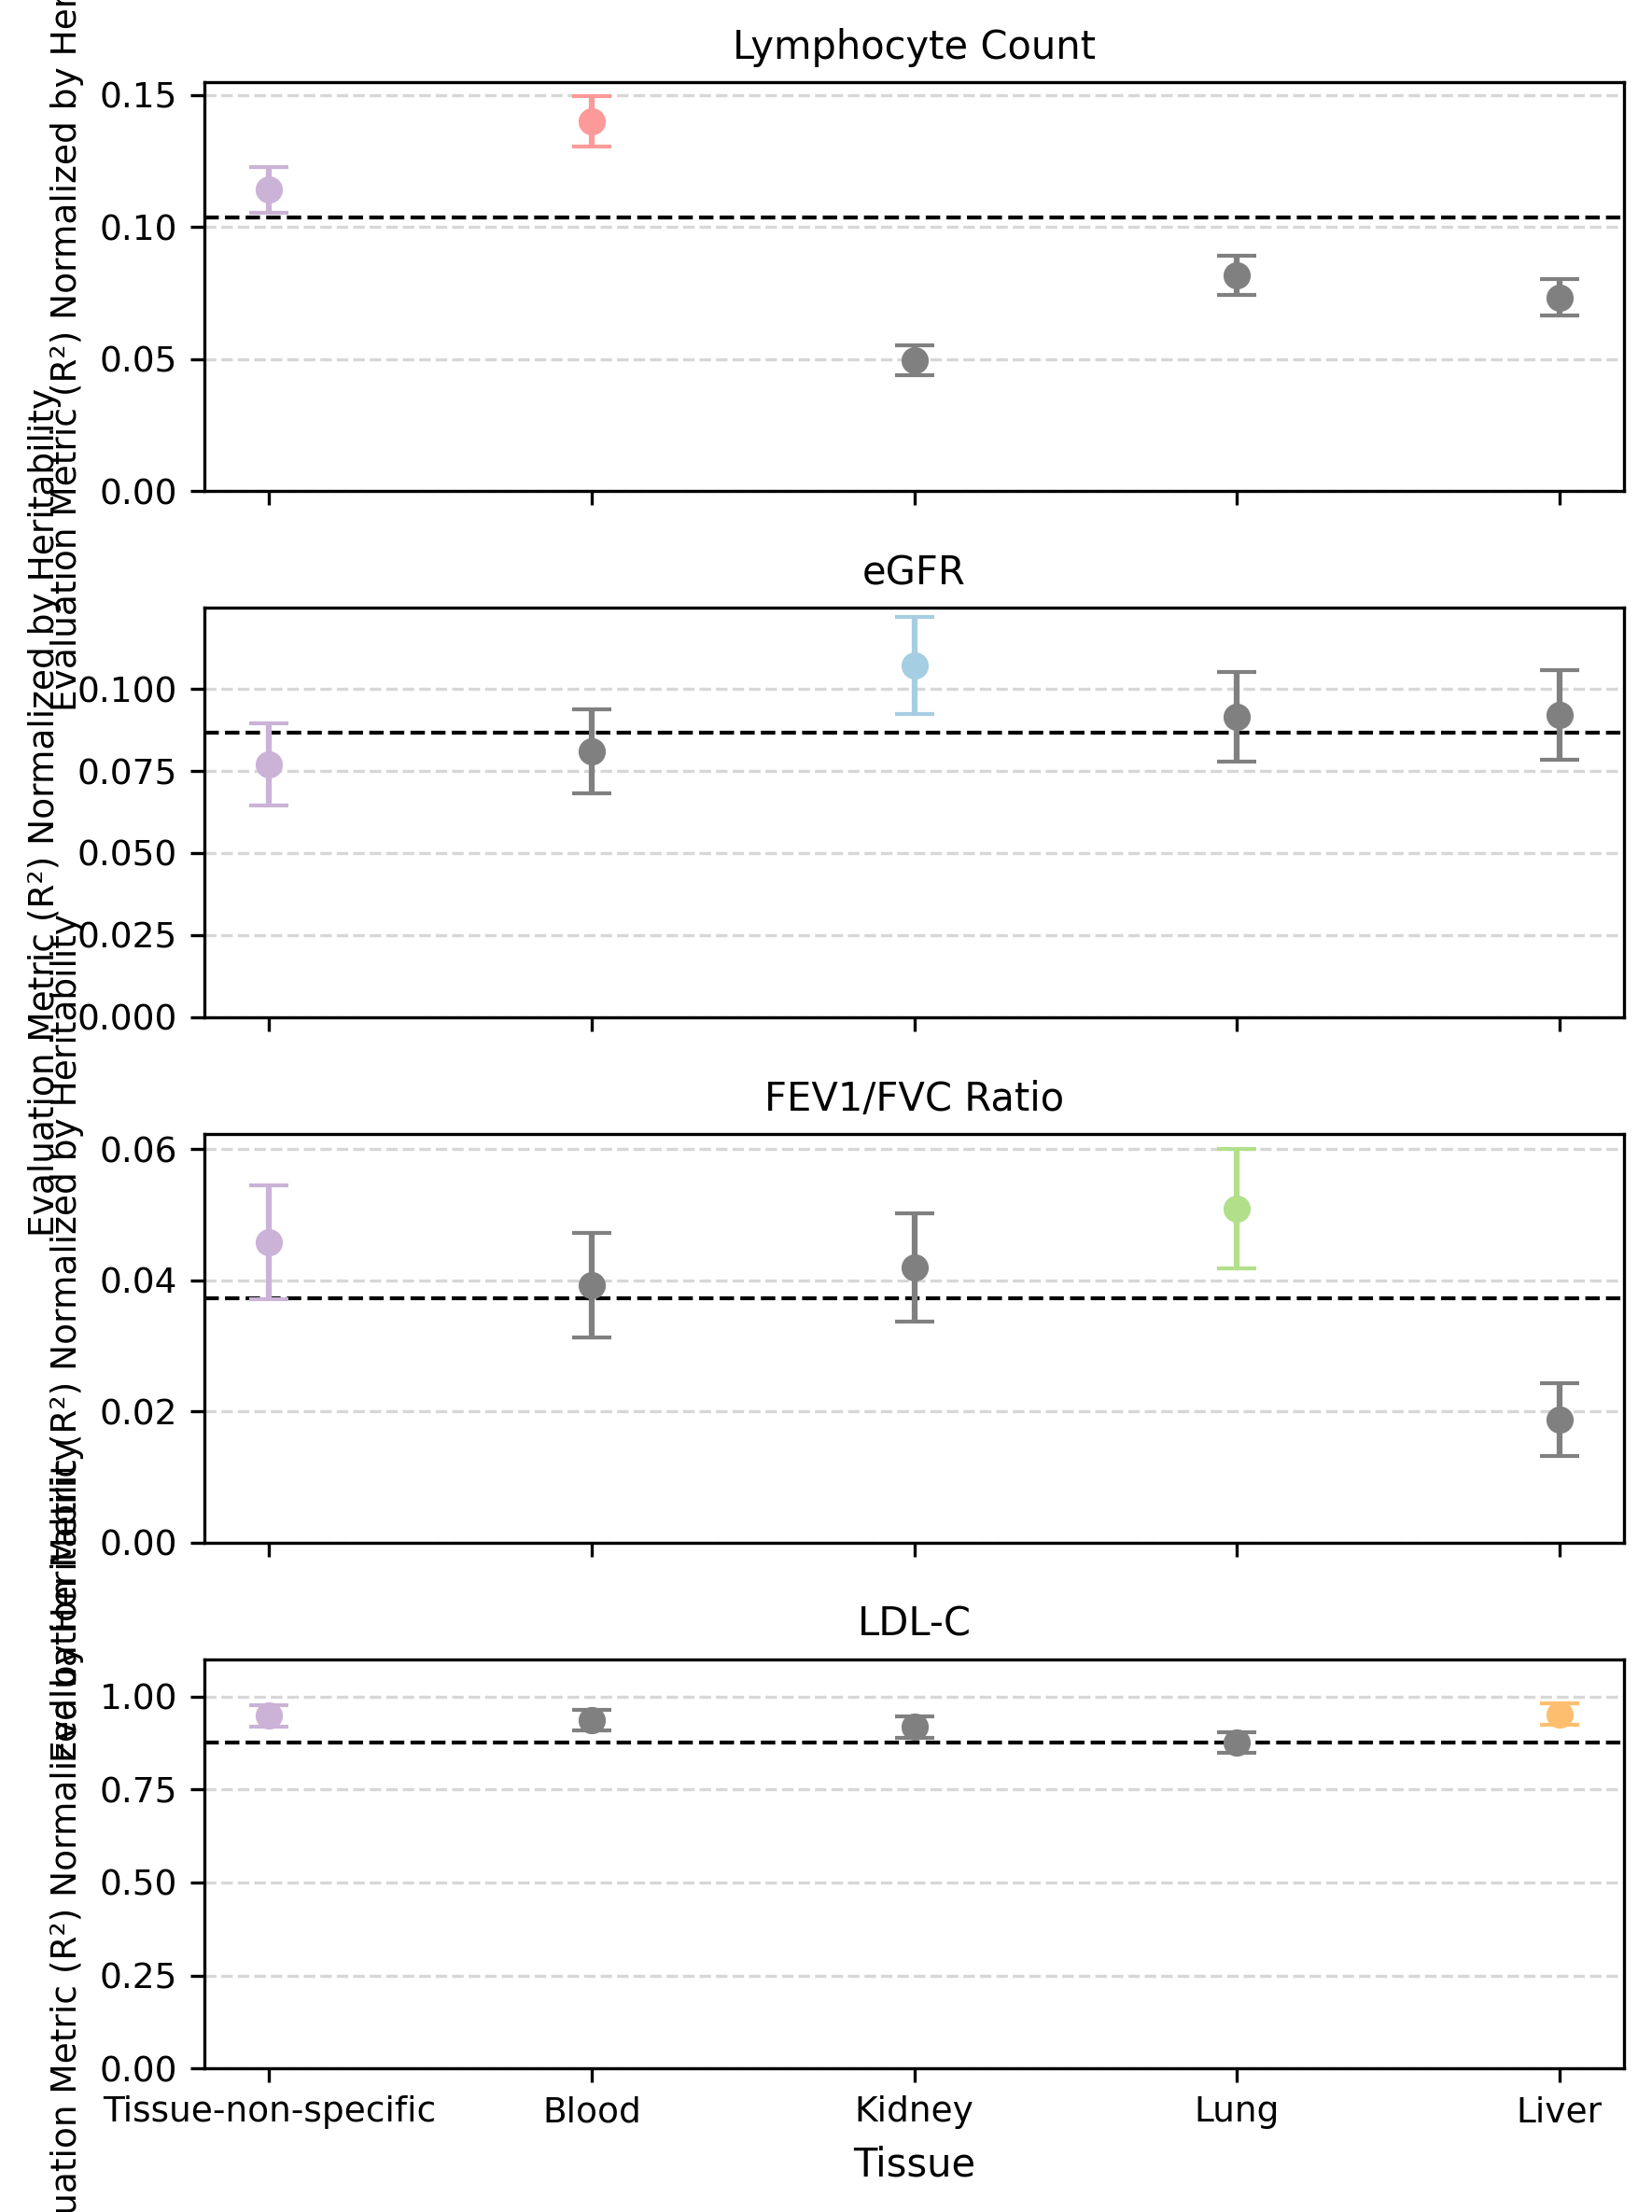

In [9]:

import matplotlib.pyplot as plt

# Define the number of traits and create subplots
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(6, 8), dpi=300, sharex=True)

custom_tissue_labels = ["Tissue-non-specific", "Blood", "Kidney", "Lung", "Liver"]

# Loop through traits and plot on separate subplots
for idx, ti in enumerate(trait):
    to_plot = eval_dfs[eval_dfs['#response'] == ti].copy()  # Filter data
    to_plot["error"] = to_plot["u_eval"] - to_plot["eval"]  # Calculate error bar

    ax = axes[idx]  # Select corresponding subplot
    
    
    baseline_value = to_plot[to_plot["tissue"] == "baseline"]["eval"].values
    if len(baseline_value) > 0:
        baseline_value = baseline_value[0]  # Get the single value
        ax.axhline(y=baseline_value/h2[idx], color='black', linestyle='--', linewidth=1, label="Baseline")
    
    to_plot = to_plot[to_plot['tissue'] != 'baseline']
    
    for i, row in to_plot.iterrows():
        if row['tissue'] == tissue_trait_dict[ti]:
            color = color_dict[row['tissue']]
        elif row['tissue'] == 'baseline':
            color = 'black'
        elif row['tissue'] == 'all':
            color = '#CAB3D6'
        else:
            color = 'gray'

        ax.errorbar(row["tissue"], row["eval"] / h2[idx], yerr=row["error"], fmt='o', capsize=5, 
                    capthick=1, color=color, label=row["tissue"])

    # Formatting for each subplot
    ax.set_title(f"{trait_name_dict[ti]}", fontsize=10)
    ax.set_ylabel("Evaluation Metric (R²) Normalized by Heritability", fontsize=9)
    if ti == 'INI20030780':
        ax.set_ylim(0, 1.1)
    else:
        ax.set_ylim(bottom=0)
    #ax.axhline(y=0, color='gray', linestyle='--', alpha=0.7)
    ax.grid(axis="y", linestyle="--", alpha=0.5)
    
    
    if idx < len(trait) - 1:
        ax.set_xticks([])
    else:
        # Set x-ticks only on the last subplot
        ax.set_xticks(range(len(custom_tissue_labels)))
        ax.set_xticklabels(custom_tissue_labels, rotation=0, ha="center", fontsize=9)
    
    ax.tick_params(axis='y', labelsize=9)
    #ax.legend()

    
    
    # Show legend only for the first subplot to avoid repetition
    #if idx == 0:
        #ax.legend()

# Shared x-axis label
plt.xlabel("Tissue")
#plt.xticks(rotation=0)
plt.tight_layout()

# Show plot
plt.show()
